In [1]:
import sys
sys.path.append('../../')

from gears import PertData, GEARS
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
data_name = 'norman_umi'
pert_data = PertData('/dfs/project/perturb-gnn/datasets/data')
pert_data.load(data_path = '/dfs/project/perturb-gnn/datasets/data/'+data_name)

Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!


In [3]:
def get_reverse(perts):
    return [t.split('+')[-1]+'+'+t.split('+')[0] for t in perts]

def remove_reverse(perts):
    return list(set(perts).difference(set(get_reverse(perts))))

def remove_duplicates_list(list_):
    import itertools
    list_.sort()
    return list(k for k,_ in itertools.groupby(list_))

class StretchOutNormalize(plt.Normalize):
    def __init__(self, vmin=None, vmax=None, low=None, up=None, clip=False):
        self.low = low
        self.up = up
        plt.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.low, self.up, self.vmax], [0, 0.5-1e-9, 0.5+1e-9, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [4]:
## Old genes of interest

norman_adata = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/data/norman_umi/perturb_processed.h5ad')
all_combos = norman_adata.obs['condition'].unique()
all_combos = [c for c in all_combos if 'ctrl' not in c]
all_singles = set([c.strip('+ctrl') for c in norman_adata.obs['condition'] 
                         if ('ctrl+' in c) or ('+ctrl' in c)])
old_genes_of_interest = np.sort(list(all_singles))

In [5]:
## New genes of interest

norman_adata = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/data/'+data_name+'/perturb_processed.h5ad')
genes_of_interest = set([c.strip('+ctrl') for c in norman_adata.obs['condition'] 
                         if ('ctrl+' in c) or ('+ctrl' in c)])
genes_of_interest = [g for g in genes_of_interest if g in list(pert_data.pert_names)]
genes_of_interest = np.sort(list(genes_of_interest))


all_possible_combos = []

for g1 in genes_of_interest:
    for g2 in genes_of_interest:
        if g1==g2:
            continue
        all_possible_combos.append(sorted([g1,g2]))
        
all_possible_combos = remove_duplicates_list(all_possible_combos)

In [6]:
singles=genes_of_interest

### Make heatmap data

In [7]:
def get_heatmaps(all_GIs, genes_of_interest):
    heatmaps = {}
    for metric in ['mag', 'dcor', 'corr_fit', 'dominance', 'eq_contr']:
        heatmaps[metric] = pd.DataFrame(columns=genes_of_interest, 
                                        index=genes_of_interest)
        for g1 in genes_of_interest:
            for g2 in genes_of_interest:
                if g1 != g2:
                    try:
                        pert = str([g1, g2])
                        z = all_GIs[pert][metric]
                    except:
                        pert = str([g2, g1])
                        z = all_GIs[pert][metric]
                    heatmaps[metric].at[g1,g2] = z
                    heatmaps[metric].at[g2,g1] = z

    heatmaps['mag'] = heatmaps['mag'].fillna(1)
    heatmaps['dcor'] = heatmaps['dcor'].fillna(0)
    heatmaps['dominance'] = heatmaps['dominance'].fillna(0)
    heatmaps['corr_fit'] = heatmaps['corr_fit'].fillna(2)
    heatmaps['eq_contr'] = heatmaps['eq_contr'].fillna(2)
    
    return heatmaps

In [8]:
#all_GIs = np.load('pertnet_umi_no_test_unc_allGI.npy', allow_pickle=True).item()
all_GIs = np.load('gears_misc_umi_no_test_allGI.npy', allow_pickle=True).item()
heatmaps = get_heatmaps(all_GIs, genes_of_interest)

#np.save('gears_misc_umi_no_test_heatmap.npy', heatmaps)

In [115]:
#all_GIs = np.load('pertnet_umi_no_test_unc_allGI.npy', allow_pickle=True).item()
#all_GIs = np.load('/dfs/user/yhr/snap/perturb_GNN/pertnet_umi_no_test_40_allGI.npy', allow_pickle=True).item()
#heatmaps_old = get_heatmaps(all_GIs, genes_of_interest)


### Clustering

In [10]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

In [11]:
mean_heatmap = np.mean([min_max_normalize(heatmaps[x]).values for x in heatmaps.keys() if x!= 'dominance'],0)

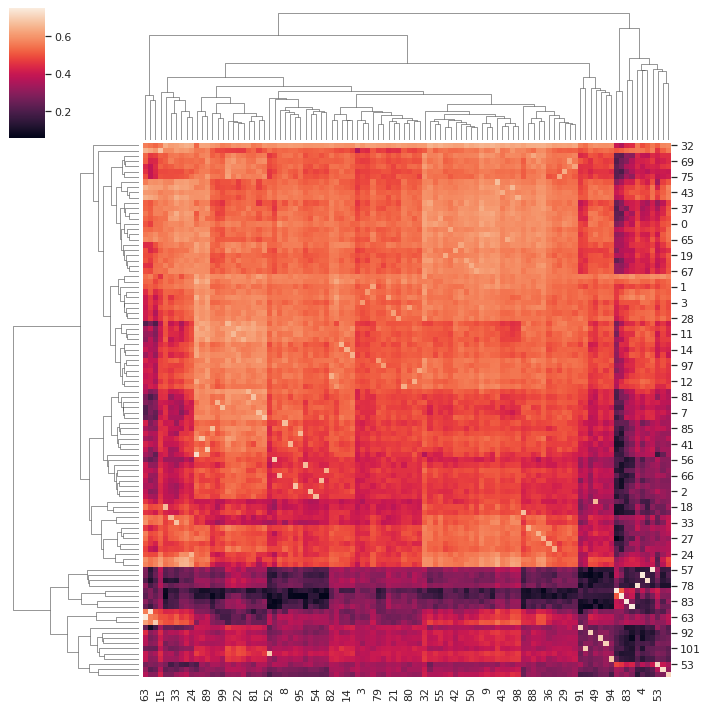

In [12]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(35,35)})
clustergrid = sns.clustermap(mean_heatmap)
cluster_idx = clustergrid.dendrogram_row.reordered_ind
cluster_idx = cluster_idx[::-1]

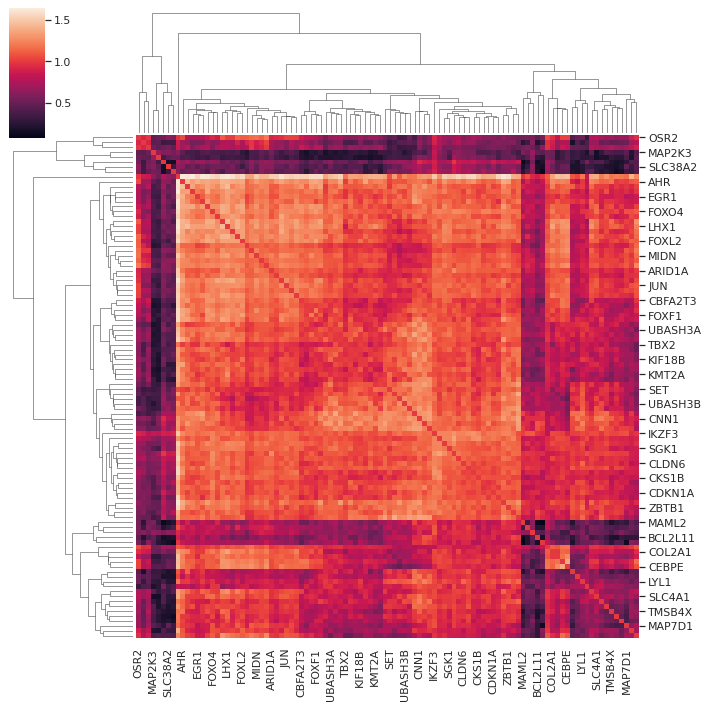

In [76]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(35,35)})
clustergrid = sns.clustermap(heatmaps['mag'])
cluster_idx = clustergrid.dendrogram_row.reordered_ind
cluster_idx = cluster_idx[::-1]

In [13]:
heatmap_order = heatmaps['mag'].columns[cluster_idx].tolist()

In [15]:
cluster_idx = None
heatmap_order = np.load('/dfs/user/yhr/snap/perturb_GNN/heatmap_order_old.npy', allow_pickle=True).astype('str')
heatmap_order = [h for h in heatmap_order if h in genes_of_interest]

### Make heatmap

In [14]:
import matplotlib 

font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [15]:
singles=genes_of_interest

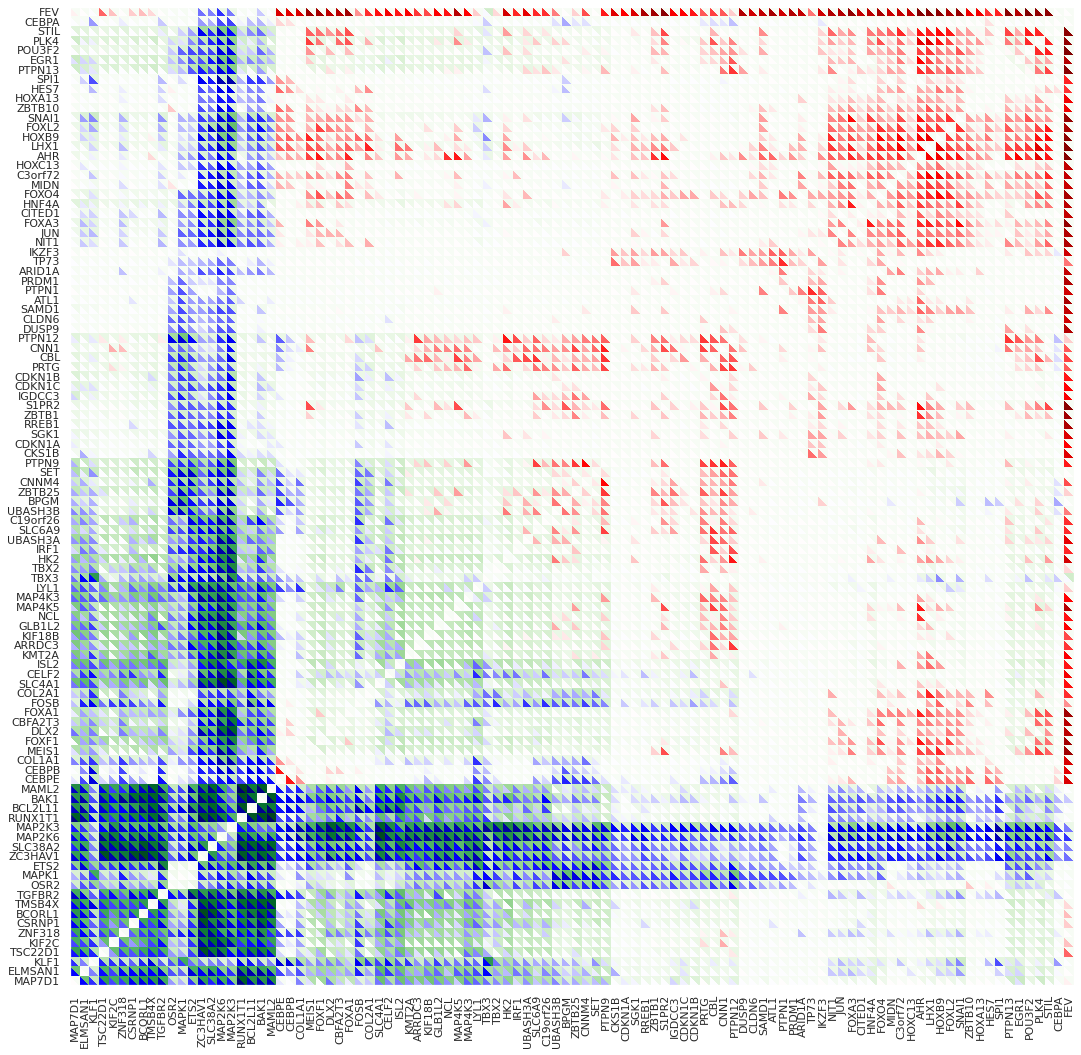

In [18]:
# without uncertainty, 40 epochs

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

M = len(singles)
N = len(singles)
x = np.arange(M + 1)
y = np.arange(N + 1)
xs, ys = np.meshgrid(x, y)

ones_mat = np.tril(np.ones(heatmaps['mag'].shape))

# for semi plot
#zs1 = np.triu(heatmaps['mag']).ravel()
#zs2 = (np.triu(heatmaps['corr_fit'])+ones_mat).ravel()
heatmaps_c={}
heatmaps_c['mag'] = heatmaps['mag'].loc[heatmap_order, heatmap_order]
heatmaps_c['corr_fit'] = heatmaps['corr_fit'].loc[heatmap_order, heatmap_order]
singles_c = heatmap_order
#singles_c = np.array(list(singles))[cluster_idx]
norm=StretchOutNormalize(vmin=0, low=0.85, up=1.15)

cmap_y = matplotlib.colors.LinearSegmentedColormap.from_list("", ["brown","orange","white"])
norm_y=StretchOutNormalize(vmin=0, low=0.8, up=0.83, vmax=0.88)


zs1 = heatmaps_c['mag'].values.ravel()
zs2 = heatmaps_c['corr_fit'].values.ravel()

plt.figure(figsize=[18,18])
#plt.figure(figsize=[3,3])
triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triang1 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles1)
triang2 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles2)

#, vmin=1.25, vmax=1.8
img1 = plt.tripcolor(triang1, zs1, cmap=plt.get_cmap('seismic'), norm=norm)
img2 = plt.tripcolor(triang2, zs2, cmap=plt.get_cmap('Greens_r'), vmax=0.90)

#cbar = plt.colorbar(img2,  pad=0.25)
#cbar = plt.colorbar(img1, pad=0.25)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Synergy', rotation=270)

plt.xlim(x[0]-0.5, x[-1]-0.5)
plt.ylim(y[0]-0.5, y[-1]-0.5)
plt.xticks(x[:-1], rotation=90)
plt.yticks(y[:-1]) 

ax=plt.gca()
ax.set_xticklabels(singles_c)
ax.set_yticklabels(singles_c)
plt.show()

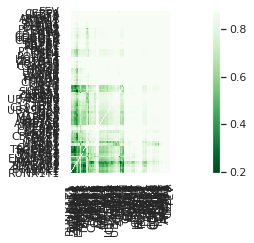

In [156]:
# creating colorbar

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

M = len(singles)
N = len(singles)
x = np.arange(M + 1)
y = np.arange(N + 1)
xs, ys = np.meshgrid(x, y)

ones_mat = np.tril(np.ones(heatmaps['mag'].shape))

# for semi plot
#zs1 = np.triu(heatmaps['mag']).ravel()
#zs2 = (np.triu(heatmaps['corr_fit'])+ones_mat).ravel()
heatmaps_c={}
heatmaps_c['mag'] = heatmaps['mag'].loc[heatmap_order, heatmap_order]
heatmaps_c['corr_fit'] = heatmaps['corr_fit'].loc[heatmap_order, heatmap_order]
singles_c = heatmap_order
norm=StretchOutNormalize(vmin=0, low=0.85, up=1.2)

cmap_y = matplotlib.colors.LinearSegmentedColormap.from_list("", ["brown","orange","white"])
norm_y=StretchOutNormalize(vmin=0, low=0.8, up=0.83, vmax=0.88)


zs1 = heatmaps_c['mag'].values.ravel()
zs2 = heatmaps_c['corr_fit'].values.ravel()

#plt.figure(figsize=[18,18])
plt.figure(figsize=[3,3])
triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triang1 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles1)
triang2 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles2)

#, vmin=1.25, vmax=1.8
img1 = plt.tripcolor(triang1, zs1, cmap=plt.get_cmap('seismic'), norm=norm)
img2 = plt.tripcolor(triang2, zs2, cmap=plt.get_cmap('Greens_r'), vmax=0.88)

font_size = 25

cbar = plt.colorbar(img2,  pad=0.25)
#cbar = plt.colorbar(img1, pad=0.25)
cbar.ax.locator_params(nbins=6)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params()
#cbar.ax.set_yticklabels('')
#cbar.ax.set_ylabel('Neomorphism', rotation=270, fontsize=font_size)
       
plt.xlim(x[0]-0.5, x[-1]-0.5)
plt.ylim(y[0]-0.5, y[-1]-0.5)
plt.xticks(x[:-1], rotation=90)
plt.yticks(y[:-1]) 

ax=plt.gca()
ax.set_xticklabels(singles_c)
ax.set_yticklabels(singles_c)

#plt.savefig('syn_cbar.svg')

plt.savefig('neo_cbar.svg')
plt.show()

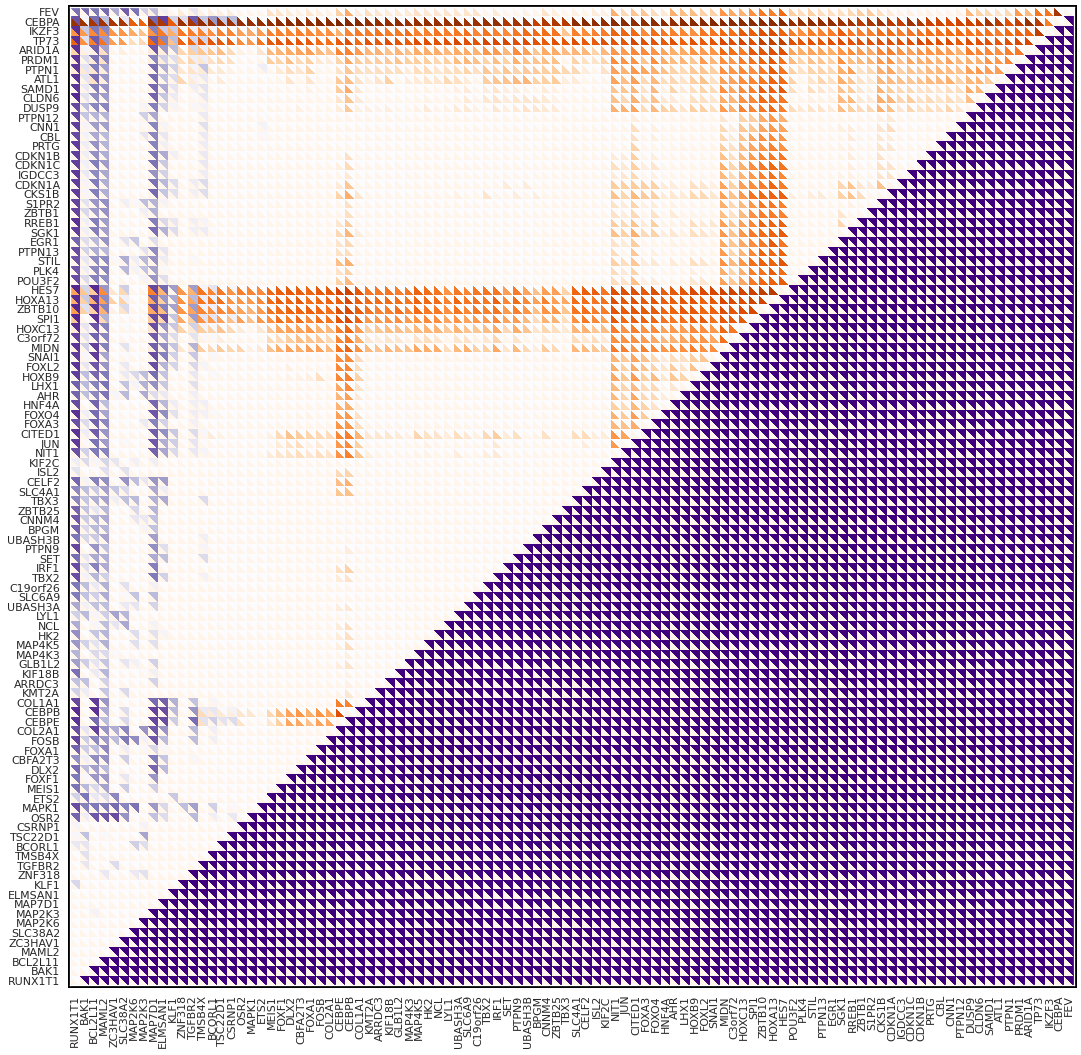

In [122]:
heatmaps_c={}
heatmaps_c['dcor'] = heatmaps['dcor'].loc[heatmap_order, heatmap_order]
heatmaps_c['eq_contr'] = heatmaps['eq_contr'].loc[heatmap_order, heatmap_order]
singles_c = heatmap_order

M = len(singles)
N = len(singles)
x = np.arange(M + 1)
y = np.arange(N + 1)
xs, ys = np.meshgrid(x, y)


zs1 = np.tril(heatmaps_c['dcor']).ravel()
zs2 = np.tril(heatmaps_c['eq_contr']).ravel()

plt.figure(figsize=[18,18])
#plt.figure(figsize=[3,3])
triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triang1 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles1)
triang2 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles2)
img1 = plt.tripcolor(triang1, zs1, cmap=plt.get_cmap('Oranges'), vmin=0.85)
img2 = plt.tripcolor(triang2, zs2, cmap=plt.get_cmap('Purples_r'), vmax=0.28)

#cbar = plt.colorbar(img2,  pad=0.15)
#cbar = plt.colorbar(img1, pad=0.55)
cbar.ax.locator_params(nbins=4)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Epistasis', rotation=270)

plt.xlim(x[0]-0.5, x[-1]-0.5)
plt.ylim(y[0]-0.5, y[-1]-0.5)
plt.xticks(x[:-1], rotation=90)
plt.yticks(y[:-1]) 

ax=plt.gca()
ax.set_xticklabels(singles_c)
ax.set_yticklabels(singles_c)

ax = plt.gca()

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('5')  

plt.savefig('epi_heatmap.svg')
plt.show()

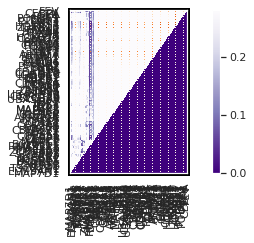

In [19]:
## Just for colorbar

heatmaps_c={}
heatmaps_c['dcor'] = heatmaps['dcor'].loc[heatmap_order, heatmap_order]
heatmaps_c['eq_contr'] = heatmaps['eq_contr'].loc[heatmap_order, heatmap_order]
singles_c = heatmap_order

M = len(singles)
N = len(singles)
x = np.arange(M + 1)
y = np.arange(N + 1)
xs, ys = np.meshgrid(x, y)


zs1 = np.tril(heatmaps_c['dcor']).ravel()
zs2 = np.tril(heatmaps_c['eq_contr']).ravel()

#plt.figure(figsize=[18,18])
plt.figure(figsize=[3,3])
triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triang1 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles1)
triang2 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles2)
#img1 = plt.tripcolor(triang1, zs1, cmap=plt.get_cmap('Oranges'), vmin=0.85)
#img2 = plt.tripcolor(triang2, zs2, cmap=plt.get_cmap('Purples_r'), vmax=0.28)

cbar = plt.colorbar(img2,  pad=0.15)
#cbar = plt.colorbar(img1, pad=0.55)
cbar.ax.locator_params(nbins=4)
cbar.ax.get_yaxis().labelpad = 15
#cbar.ax.set_ylabel('Epistasis', rotation=270)

plt.xlim(x[0]-0.5, x[-1]-0.5)
plt.ylim(y[0]-0.5, y[-1]-0.5)
plt.xticks(x[:-1], rotation=90)
plt.yticks(y[:-1]) 

ax=plt.gca()
ax.set_xticklabels(singles_c)
ax.set_yticklabels(singles_c)

ax = plt.gca()

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('5')  
ax.axis('off')

plt.savefig('epi_cbar.svg')
plt.show()

### With uncertainty mode turned on

In [55]:
all_uncs = np.load('pertnet_umi_no_test_unc_jfix_alluncs.npy', allow_pickle=True).item()

In [65]:
all_uncs2 = np.load('pertnet_umi_no_test_unc_alluncs.npy', allow_pickle=True).item()